[In English](https://marieevelb.github.io/jupyter-notebook/use_case_profits_en/)  

![ECCC logo](https://eccc-msc.github.io/open-data/img_eccc-logo.png)  

[TdM](https://eccc-msc.github.io/open-data/readme_fr/) > [Aperçu de l'utilisation](https://eccc-msc.github.io/open-data/usage/readme_fr/) > Requêtes WMS en Python

# Cas d'utilisation : profits anticipés selon la probabilité de précipitations

## Introduction

Les données des services web géospatiaux [GeoMet du SMC](https://eccc-msc.github.io/open-data/msc-geomet/readme_fr/) peuvent aisément être utilisées pour prévoir la demande associée à certains produits ou services. Cet exemple de cas d'utilisation vous montrera comment extraire et traiter les données météorologiques brutes à l'aide du langage de programmation [Python](https://www.python.org/) afin de créer un outil qui permet de calculer les profits anticipés de la vente d'un produit dont la demande est affectée par les conditions météorologiques. Il vous permettra d'apprendre comment :
* Accéder aux données météorologiques de GeoMet du SMC et les interroger;
* Effectuer des requêtes pour obtenir les données d'une couche spécifique à un lieu précis; 
* Effectuer des requêtes temporelles;
* Afficher les résultats sous forme de graphique et de tableau.

Pour accéder à la version interactive du code source de ce Jupyter Notebook, cliquez sur la bannière ci-dessous.

[![badge](https://img.shields.io/badge/Version%20interactive-binder-F5A252.svg?logo=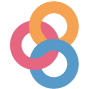)](https://gesis.mybinder.org/binder/v2/gh/marieevelb/jupyter-notebook/d2805ebc1e0015db7db92e8a9929603fa43cb316?filepath=use_case_profits_fr.ipynb)


## Création d'un outil de calcul des profits anticipés

Prenons la situation suivante : un propriétaire de kiosque de souvenirs à Vancouver souhaite calculer les profits qu'il anticipe de faire grâce à la vente de parapluies à l'aide des prévisions météorologiques d'Environnement et Changement climatique Canada. En effet, ses ventes de parapluies augmentent drastiquement les jours où la probabilité qu'il y ait un minimum de 5 mm de précipitations est de 30% et plus. Considérant que le kiosque est ouvert de 9:00 le matin à 9:00 le soir, celui-ci souhaite calculer les profits qu'il prévoit faire dans les prochains jours selon les prévisions météorologiques obtenues avec les services web géospatiaux GeoMet du SMC.

Afin de déterminer le nombre de parapluies qui devraient être vendus, la première étape est d'effectuer une requête avec le [standard Web Map Service (WMS)](https://eccc-msc.github.io/open-data/msc-geomet/web-services_fr/#web-map-service-wms) du SMC afin d'obtenir la probabilité qu'il y ait 5 mm ou plus de précipitations pour l'heure, la date et le lieu désiré à l'aide du langage de programmation Python. Pour réaliser cette étape, il faut tout d'abord importer les modules Python nécessaires et déterminer les paramètres de la requête comme la couche de données désirée, le lieu et le fuseau horaire local. La couche qui sera utilisée est celle du [Système régional de prévision d'ensemble (SRPE)](https://eccc-msc.github.io/open-data/msc-data/nwp_reps/readme_reps_fr/) qui contient la probabilité en pourcentage que la quantité de précipitations soit égale ou supérieure à 5 mm (``REPS.DIAG.3_PRMM.ERGE5``).

In [1]:
# Importation des modules Python 
from datetime import datetime, timedelta
import re

# Les modules suivants doivent avoir été préalablement installés sur 
# votre ordinateur pour utiliser le code hors de Jupyter Notebook
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy
from owslib.wms import WebMapService
import pandas
from tabulate import tabulate

# Choix des paramètres
# Couche de données désirée :
layer = 'REPS.DIAG.3_PRMM.ERGE5'
# Coordonnées de l'endroit pour lequel on souhaite obtenir des prévisions :
y, x = 49.288, -123.116
# Fuseau horaire local. Dans cet exemple, le fuseau horaire est UTC-07:00 :
time_zone = -7

Une fois les paramètres sélectionnés, il faut calculer les valeurs du paramètre ``bbox`` de la requête (lieu visé par la requête).

In [2]:
# Calcul du paramètre bbox
min_x, min_y, max_x, max_y = x - 0.25, y - 0.25, x + 0.25, y + 0.25

Il faut ensuite se connecter au service WMS afin d'accéder aux métadonnées de la couche de données désirée.

In [3]:
# Connexion au service WMS
wms = WebMapService('https://geo.weather.gc.ca/geomet?SERVICE=WMS' +
                    '&REQUEST=GetCapabilities',
                    version='1.3.0')

Le temps de début et de fin des prévisions disponibles ainsi que l'intervalle de temps entre les prévisions peuvent être récupérés grâce à une requête ``GetCapabilities``. Dans cette requête, ``dimensions`` fait référence à la section du même nom dans les métadonnées qui contient les informations liées au temps. ``dimensions`` étant un dictionnaire python, il est possible de récupérer les informations recherchées en utilisant les clés du dictionnaire et en utilisant la méthode ``split`` pour séparer les chaînes de caractères situées de part et d'autre du caractère ``/``. Pour l'intervalle de temps, la méthode ``re.sub`` permet de récupérer uniquement les chiffres de l'expression présente dans les métadonnées en remplaçant tout les autres caractères par un espace vide.

Par la suite, une boucle ``while`` va permettre de générer la date et l'heure de toutes les prévisions disponibles pour le fuseau horaire UTC±00:00 entre le temps de début et le temps de fin des prévisions. Ces informations sont nécessaires pour réaliser la requête WMS. Cette même boucle ``while`` sera également utilisée pour obtenir la date et l'heure locale de chaque prévision disponible. Cela va permettre d'afficher les résultats obtenus aux heures locales pour faciliter l'interprétation des résultats.

In [4]:
# Extraction des informations liées au temps
# des prévisions disponibles à partir des métadonnées
def time_parameters(layer):
    start_time, end_time, interval = (wms[layer]
                                      .dimensions['time']['values'][0]
                                      .split('/')
                                      )
    iso_format = '%Y-%m-%dT%H:%M:%SZ'
    start_time = datetime.strptime(start_time, iso_format)
    end_time = datetime.strptime(end_time, iso_format)
    interval = int(re.sub(r'\D', '', interval))
    return start_time, end_time, interval


start_time, end_time, interval = time_parameters(layer)

# Afin d'utiliser une heure de début et de fin locale spécifique,
# enlevez le # au début des lignes suivantes et remplacez
# les valeurs de start_time et end_time par les valeurs désirées :
# start_time = 'AAAA-MM-JJThh:00'
# end_time = 'AAAA-MM-JJThh:00'
# fmt = '%Y-%m-%dT%H:%M'
# start_time = datetime.strptime(start_time, fmt) - timedelta(hours=time_zone)
# end_time = datetime.strptime(end_time, fmt) - timedelta(hours=time_zone)

# Calcul de la date et de l'heure de chaque prévision
# pour le fuseau horaire UTC±00:00 (variable time) 
# et pour le fuseau horaire local (variable local_time)
time = [start_time]
local_time = [start_time + timedelta(hours=time_zone)]
while time[-1] < end_time:
    time.append(time[-1] + timedelta(hours=interval))
    local_time.append(time[-1] + timedelta(hours=time_zone))

La requête peut maintenant être envoyée au service WMS. Pour obtenir la probabilité qu'il y ait un minimum de 5 mm de précipitations à chaque date et heure désirée, une boucle ``for`` est utilisée afin de refaire la requête pour chaque heure de prévision déterminée précédemment. Comme le résultat de chacune de ces requêtes est une réponse contenant différentes informations, il faut ensuite extraire la probabilité qu'il y ait un minimum de 5 mm de précipitations de la réponse obtenue. Pour y arriver, il est possible d'utiliser les expressions régulières (module ``re``) afin de retrouver une chaîne de caractères. Les expressions régulières, souvent appelées regex, sont des expressions décrivant des ensembles de chaînes de caractères possibles. Dans cet exemple, les regex utilisées sont ``\s`` (espace blanc), ``\d`` (caractère numérique), ``*`` (0 ou plusieurs caractères du type mentionné juste avant) et ``+`` (1 ou plusieurs caractères du type mentionné juste avant). Ainsi, la méthode ``re.findall`` permet de trouver toutes les chaînes de caractères correspondant à l'expression qui lui est fournie. Les méthodes ``re.sub`` et ``strip`` sont également utilisées pour retirer les éléments qui entourent notre valeur.

In [5]:
# Boucle pour effectuer les requêtes et extraire les probabilités
def request(layer): 
    info = []
    pixel_value = []
    for timestep in time:
        # Requête GetFeatureInfo
        info.append(wms.getfeatureinfo(layers=[layer],
                                       srs='EPSG:4326',
                                       bbox=(min_x, min_y, max_x, max_y),
                                       size=(100, 100),
                                       format='image/jpeg',
                                       query_layers=[layer],
                                       info_format='text/plain',
                                       xy=(50, 50),
                                       feature_count=1,
                                       time=str(timestep.isoformat()) + 'Z'
                                       ))
        # Extraction des probabilités des résultats de la requête
        text = info[-1].read().decode('utf-8')
        pixel_value.append(str(re.findall(r'value_0\s+\d*.*\d+', text)))
        pixel_value[-1] = float(
            re.sub('value_0 = \'', '', pixel_value[-1])
            .strip('[""]')
        )
    
    return pixel_value

pixel_value = request(layer)


Les probabilités obtenues peuvent être visualisées sous la forme d'un graphique interactif facile à exporter grâce au module ``matplotlib``. Sur Jupyter Notebook, le côté interactif du graphique peut être activé avec la commande «magic» ``%matplotlib notebook``.

<IPython.core.display.Javascript object>


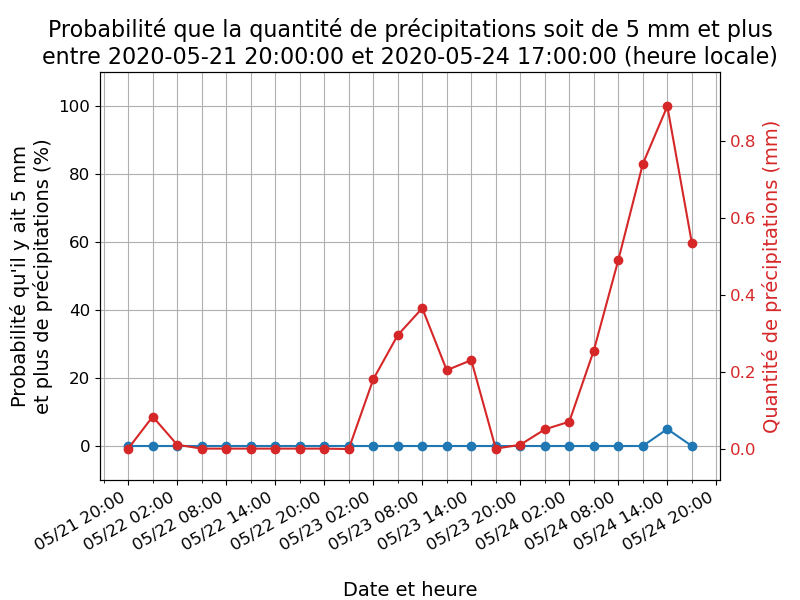

In [6]:
# Prochaine ligne à retirer si le code est utilisé hors de Jupyter Notebook
%matplotlib notebook


# Création d'une fonction permettant de mieux aligner deux axes y ensemble
def align_yaxis(ax, ax2):
    y_lims = numpy.array([ax.get_ylim() for ax in [ax, ax2]])

    # Normalisation des limites des axes y
    y_magnitudes = (y_lims[:,1] - y_lims[:,0]).reshape(len(y_lims),1)
    y_lims_normalized = y_lims / y_magnitudes

    # Obtention de l'étendue combinée des axes y
    y_new_lims_normalized = numpy.array([numpy.min(y_lims_normalized), 
                                         numpy.max(y_lims_normalized)])

    # Dénormalisation de l'étendue combinée pour obtenir 
    # les nouvelles limites d'axe
    new_lim1, new_lim2 = y_new_lims_normalized * y_magnitudes
    ax2.set_ylim(new_lim2)

    
# Création d'une fonction pour faire le graphique
def fig(x, y, title, xlabel, ylabel, ylim, color = 'black', y2 = '', y2label = ''):
    # Taille du graphique et des polices de caractères
    params = {'legend.fontsize': '14',
              'figure.figsize': (8, 6),
              'axes.labelsize': '14',
              'axes.titlesize': '16',
              'xtick.labelsize': '12',
              'ytick.labelsize': '12'}
    plt.rcParams.update(params)

    # Création du graphique et de son style
    fig, ax = plt.subplots()
    ax.plot(x, y, marker='o')

    # Titres
    plt.title(title)
    plt.xlabel(xlabel)
    ax.set_ylabel(ylabel, color=color)

    # Étendue de l'axe des y
    ax.set_ylim(ylim)
    ax.tick_params(axis='y', labelcolor=color)
    
    # Grille
    plt.grid(True, which='both')
    
    # Ajout d'un deuxième jeu de données
    if y2 is not None:
        ax2 = plt.twinx()
        ax2.plot(x, y2, marker='o', color='tab:red')
        # Titre du deuxième axe y
        ax2.set_ylabel(y2label, color='tab:red')
        # Étendue et marques du deuxième axe y
        ax2.set_ylim(0, (max(y2) * 1.1))
        ax2.tick_params(axis='y', labelcolor='tab:red')
        align_yaxis(ax, ax2)

    # Format de la date sur l'axe des x
    plt.gcf().autofmt_xdate()
    my_format = mdates.DateFormatter('%m/%d %H:%M')
    plt.gca().xaxis.set_major_formatter(my_format)

    # Graduation de l'axe des x selon le nombre de points sur le graphique
    # Variable contenant les heures pour lesquelles il y aura des étiquettes: 
    hour = []
    for timestep in x:
        hour.append(int(timestep.strftime('%#H')))

    # Détermination de la fréquence des marques et étiquette sur l'axe des x
    if len(hour) < 8:
        # Graduation plus précise si peu de valeurs
        ax.xaxis.set_major_locator(mdates.HourLocator(byhour=hour))
    elif len(hour) > 8 and len(hour) <25:
        ax.xaxis.set_major_locator(mdates.HourLocator(byhour=hour, interval=2))
        ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=hour))
    else:
        # Graduation plus grossière s'il y a beaucoup de valeurs
        ax.xaxis.set_major_locator(mdates.DayLocator())
        ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=(0, 12)))
    
    return fig

# Ajout de la quantité de précipitation au graphique
# Vérification de la compatibilité des paramètres temporels :
start_time1, end_time1, interval1 = time_parameters('REPS.DIAG.3_PRMM.ERMEAN')

if (start_time1 == start_time
        and end_time1 == end_time
        and interval1 == interval):
    # Requête GetFeatureInfo
    y2 = request(layer = 'REPS.DIAG.3_PRMM.ERMEAN')
    y2label = 'Quantité de précipitations (mm)'
else:
    y2 = None
    y2label = None

# Utilisation de la fonction fig pour générer le graphique
fig(x = local_time,
    y = pixel_value,
    title = ('Probabilité que la quantité de précipitations ' +
             f'soit de 5 mm et plus\nentre {local_time[0]} et ' +
             f'{local_time[-1]} (heure locale)'),
    xlabel = '\nDate et heure',
    ylabel = 'Probabilité qu\'il y ait 5 mm\net plus de précipitations (%)',
    ylim = (-10, 110),
    y2 = y2,
    y2label = y2label
    )

# Affichage du graphique
plt.show()

Une fois les probabilités obtenues, le propriétaire doit calculer les profits que rapporte la vente de parapluie. Comme mentionné plus tôt, il sait qu'en moyenne, le kiosque vend 3 parapluies par jour lorsque la probabilité qu'il y ait un minimum de 5 mm de pluie est inférieure à 30%. À ce nombre s'ajoutent en moyenne 10 parapluies par heure lorsque la probabilité est de 30% et le nombre de parapluies continue à augmenter de manière linéaire pour atteindre une moyenne de 30 parapluies par heure lorsque la probabilité est de 100%. Le nombre de parapluies vendus par heure si la probabilité de précipitation est de 30% et plus peut être calculé à l'aide des équations suivantes:

$$ m = \frac{y_2 - y_1}{x_2 - x_1} = \frac{30 - 10}{100 - 30}$$

$$ n_{parapluies} = 10 + m * (probabilité - 30)$$

Sachant que chaque parapluie lui rapporte 10,00$, il est possible de calculer les profits pour les trois prochains jours avec le code qui suit.

In [7]:
# Nombre de parapluies vendus lorsqu'il y a moins de 30% 
# de probabilité qu'il y ait 5 mm et plus de précipitations 
base = 3

# Profit par parapluie
umbrella_profit = 10.00

# Données pour le calcul de la pente
# Lorsque la probabilité est de 30%...
x1 = 30
# ... 10 parapluies sont vendus chaque heure
y1 = 10
# Lorsque la probabilité est de 100%...
x2 = 100
# ... 30 parapluies sont vendus chaque heure
y2 = 30

# Calcul de la pente
slope = ((y2-y1)/(x2-x1))

# Heures d'ouverture
opening = '09:00:00'
opening = datetime.strptime(opening, '%H:%M:%S')
closing = '21:00:00'
closing = datetime.strptime(closing, '%H:%M:%S')

# Obtention des heures de prévision incluses dans les heures d'ouverture
open_hours = []
for timestep in local_time:
    if (timestep.time() > opening.time() 
            and timestep.time() < closing.time()):
        open_hours.append(timestep)

# Calcul du nombre de parapluies vendus chaque jour, peu importe 
# les conditions météorologiques
opening_interval = (opening + timedelta(hours=interval)).time()
umbrella = []
for timestep in local_time:
    new_day = timestep.time() < opening_interval
    if (umbrella == [] or new_day) and timestep in open_hours:
        umbrella.append(base)      
    else:
        umbrella.append(0)

# Calcul du nombre de parapluies vendus chaque jour selon les conditions
# météorologiques et des profits cumulatifs anticipés de la vente de parapluies
cumulative_profit = []
for index, probability in enumerate(pixel_value):
    # Équation pour obtenir le nombre de parapluies vendus par heure
    eq = y1 + round((probability - 30) * slope)
    # Équation pour obtenir le nombre de parapluies vendus entre 2 prévisions
    eq2 = eq * interval 
    if local_time[index] in open_hours and probability > 30:
        if index == 0:
            umbrella[index] = umbrella[index] + eq2
        else: 
            umbrella[index] = umbrella[index] + umbrella[index - 1] + eq2
    elif index != 0:
        umbrella[index] = umbrella[index] + umbrella[index-1]                            
    cumulative_profit.append(umbrella[index] * umbrella_profit)        

Les résultats obtenus peuvent alors être visualisés sous la forme d'un graphique grâce à la fonction ``fig`` créée plus tôt.

<IPython.core.display.Javascript object>


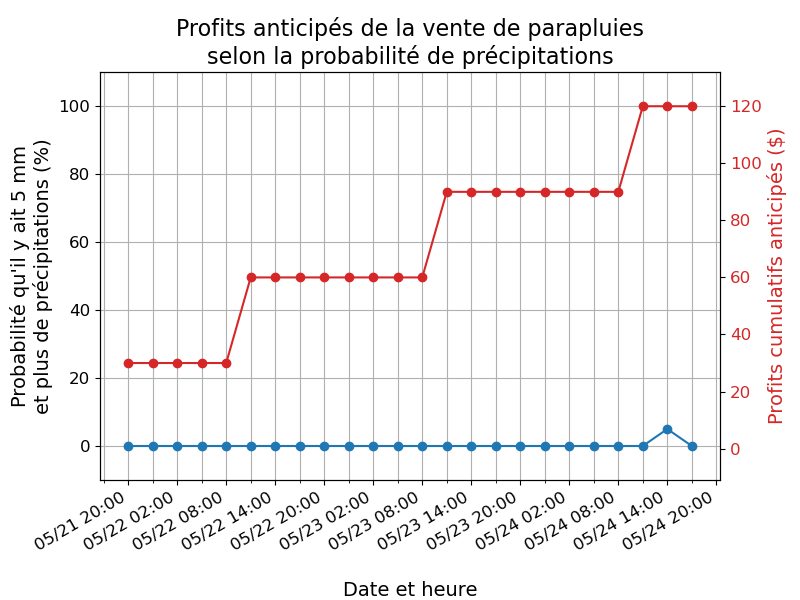

In [8]:
# Création du graphique
fig(x=local_time,
    y=pixel_value,
    title=('Profits anticipés de la vente de parapluies\n' +
           'selon la probabilité de précipitations'),
    xlabel='\nDate et heure',
    ylabel='Probabilité qu\'il y ait 5 mm\net plus de précipitations (%)',
    ylim=(-10, 110),
    y2=cumulative_profit,
    y2label='Profits cumulatifs anticipés ($)'
    )

# Affichage du graphique
plt.show()

Les profits cumulatifs anticipés peuvent également être visualisés sous la forme d'un tableau synthèse et exportés en format CSV si désiré.

In [9]:
# Obtention des probabilités et des profits cumulatifs
# uniquement pour les heures d'ouverture du kiosque
probability = []
profit = []
for index, timestep in enumerate(local_time):
    if timestep in open_hours:
        probability.append(pixel_value[index])
        profit.append(cumulative_profit[index])

# Création du tableau
profit_df = pandas.DataFrame({'Date et heure locale':  open_hours,
                              'Probabilité (%)': probability,
                              'Profits cumulatifs anticipés ($)': profit
                              })

# Affichage du tableau
print('Tableau 1 : Profits cumulatifs anticipés' +
      ' selon la probabilité de précipitations')
print(tabulate(profit_df,
               headers='keys',
               tablefmt='pretty',
               showindex=False))

# Sauvegarde du tableau en format CSV
# Enlever le # au début des lignes suivantes:
# profit_df.to_csv('profit.csv',
#                 sep=';',
#                 index=False,
#                 encoding='utf-8-sig')


Tableau 1 : Profits cumulatifs anticipés selon la probabilité de précipitations
+----------------------+-----------------+----------------------------------+
| Date et heure locale | Probabilité (%) | Profits cumulatifs anticipés ($) |
+----------------------+-----------------+----------------------------------+
| 2020-05-21 20:00:00  |       0.0       |               30.0               |
| 2020-05-22 11:00:00  |       0.0       |               60.0               |
| 2020-05-22 14:00:00  |       0.0       |               60.0               |
| 2020-05-22 17:00:00  |       0.0       |               60.0               |
| 2020-05-22 20:00:00  |       0.0       |               60.0               |
| 2020-05-23 11:00:00  |       0.0       |               90.0               |
| 2020-05-23 14:00:00  |       0.0       |               90.0               |
| 2020-05-23 17:00:00  |       0.0       |               90.0               |
| 2020-05-23 20:00:00  |       0.0       |               90.0 

## Conclusion

Grâce à cet outil, Arthur a maintenant un aperçu des profits provenant de la vente de parapluies qu'il peut s'attendre à faire dans les prochains jours. Suite à la lecture de cet exemple de cas d'utilisation, vous devriez être en mesure de savoir comment accéder à un WMS, effectuer des requêtes incluant des requêtes temporelles et afficher les résultats obtenus sous forme de graphique et de tableau. En changeant les paramètres de la requête et les étapes de traitement des données obtenues, il est possible d'adapter cet exemple pour répondre à vos besoins.